## Station Location Features

In [1]:
import pandas as pd
import Useful_functions_for_stations
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap


In [72]:
#bluebikes = pd.read_csv('C:/Users/lauri/PycharmProjects/DSML_Data/bluebikes_idle_time_v4.csv')
bluebikes = pd.read_csv('C:/Users/Admin/PycharmProjects/DSML_Data/bluebikes_idle_time_v3.csv')
bluebikes

,start_time,end_time,start_station_id,end_station_id,bike_id,weekday,idle_time
0,2017-01-01 00:06:58,2017-01-01 00:12:49,67,139,644,6,0 days 00:06:58
1,2017-01-01 00:13:16,2017-01-01 00:28:07,36,10,230,6,0 days 00:13:16
2,2017-01-01 00:16:17,2017-01-01 00:44:10,36,9,980,6,0 days 00:16:17
3,2017-01-01 00:21:22,2017-01-01 00:33:50,46,19,1834,6,0 days 00:21:22
4,2017-01-01 00:30:06,2017-01-01 00:40:28,10,8,230,6,0 days 00:01:59
...,...,...,...,...,...,...,...
3081456,2018-12-31 23:05:54,2018-12-31 23:08:31,43,40,3050,0,0 days 05:03:27
3081457,2018-12-31 23:31:50,2018-12-31 23:39:14,107,90,2673,0,0 days 06:00:40
3081458,2018-12-31 23:48:46,2018-12-31 23:56:55,19,179,4440,0,0 days 06:07:52
3081459,2018-12-31 23:54:16,2018-12-31 23:57:17,352,36,3605,0,0 days 06:59:37


In [3]:
bluebikes_stations = pd.read_csv('C:/Users/Admin/PycharmProjects/DSML_Data/bluebikes_stations.csv')
bluebikes_stations_dist = bluebikes_stations.copy()
bluebikes_stations.head()

,station_id,lat,lon
0,67,42.358100,-71.093198
1,139,42.361780,-71.108100
2,36,42.349792,-71.077338
3,10,42.350406,-71.108279
4,9,42.351187,-71.115852


Density-based feature: Calculate density of stations within a certain radius around each station. High density might imply high competition which could lead to higher idle times.

In [4]:
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic

In [5]:
geodata = gpd.GeoDataFrame(bluebikes_stations, geometry = gpd.points_from_xy(bluebikes_stations.lon, bluebikes_stations.lat))

geodata.set_crs(epsg=4326, inplace=True)

geodata = geodata.to_crs(epsg=3857)

buffer_radius = 1000 # = 1000 meter

geodata['buffer'] = geodata['geometry'].buffer(buffer_radius)
# Calculate number of stations within the radius around a station
geodata['station_density'] = geodata.apply(lambda row: geodata.within(row['buffer']).sum() - 1, axis=1)
# Convert station_density to per square km
geodata['station_density'] = geodata['station_density'] / (3.1416* (buffer_radius/1000)**2)



In [6]:
geodata

,station_id,lat,lon,geometry,buffer,station_density
0,67,42.358100,-71.093198,POINT (-7914058.600 5214772.943),"POLYGON ((-7913058.600 5214772.943, -7913063.4...",0.954927
1,139,42.361780,-71.108100,POINT (-7915717.430 5215327.402),"POLYGON ((-7914717.430 5215327.402, -7914722.2...",2.546473
2,36,42.349792,-71.077338,POINT (-7912293.113 5213521.392),"POLYGON ((-7911293.113 5213521.392, -7911297.9...",2.864782
3,10,42.350406,-71.108279,POINT (-7915737.409 5213613.945),"POLYGON ((-7914737.409 5213613.945, -7914742.2...",1.591546
4,9,42.351187,-71.115852,POINT (-7916580.435 5213731.525),"POLYGON ((-7915580.435 5213731.525, -7915585.2...",1.273237
...,...,...,...,...,...,...
308,229,42.345033,-71.096649,POINT (-7914442.783 5212804.682),"POLYGON ((-7913442.783 5212804.682, -7913447.5...",3.501401
309,374,42.356683,-71.061666,POINT (-7910548.525 5214559.533),"POLYGON ((-7909548.525 5214559.533, -7909553.3...",4.456328
310,376,42.360274,-71.128525,POINT (-7917991.131 5215100.408),"POLYGON ((-7916991.131 5215100.408, -7916995.9...",0.636618
311,377,42.379273,-71.103419,POINT (-7915196.400 5217963.142),"POLYGON ((-7914196.400 5217963.142, -7914201.2...",2.228164


Distance-based feature: There are important locations in Boston like the city center, the universities or popular train stations. Bike stations closer to those locations might be used more frequently which could lead to lower idle times

In [7]:
# Important locations in Boston
locations = {
    'city_center': (42.360082, -71.058880), # Boston City Center
    'boston_university': (42.350503, -71.105399), # Boston University
    'fenway_park': (42.346676, -71.097218), # Fenway Park
    'harvard_university': (42.373611, -71.109733), # Harvard University
    'mit': (42.360091, -71.094160), # Massachusetts Institute of Technology
    'boston_common': (42.355443, -71.066163), # Boston Common: public park in downtown
    'boston_public_garden': (42.353865, -71.071342), # Boston Public Garden
    'newbury_street': (42.349846, -71.083415), # Newbury Street (shopping district)
    'south_station': (42.352175, -71.055242), # South Station (major train/subway station)
    'north_station': (42.365577, -71.061245), # North Station (major train/subway station)
    'back_bay_station': (42.347351, -71.075187), # Back Bay Station (major train/subway station)
}
# Calculate distance to each location
for loc_name, loc_coord in locations.items():
    bluebikes_stations_dist[loc_name + '_distance'] = bluebikes_stations_dist.apply(lambda row: geodesic((row['lat'], row['lon']), loc_coord).km, axis=1)

bluebikes_stations_dist

,station_id,lat,lon,city_center_distance,boston_university_distance,fenway_park_distance,harvard_university_distance,mit_distance,boston_common_distance,boston_public_garden_distance,newbury_street_distance,south_station_distance,north_station_distance,back_bay_station_distance
0,67,42.358100,-71.093198,2.835790,1.312488,1.311493,2.196322,0.234932,2.246784,1.861094,1.220776,3.195646,2.760200,1.904668
1,139,42.361780,-71.108100,4.059136,1.272305,1.902310,1.321014,1.163583,3.525886,3.153329,2.427624,4.483532,3.882721,3.149924
2,36,42.349792,-71.077338,1.902449,2.313407,1.674192,3.757982,1.797120,1.114398,0.669948,0.500724,1.839755,2.198291,0.323908
3,10,42.350406,-71.108279,4.209433,0.237541,1.001153,2.580400,1.584456,3.514814,3.067487,2.049614,4.374321,4.225473,2.747706
4,9,42.351187,-71.115852,4.796679,0.864608,1.615064,2.541403,2.042611,4.121133,3.679314,2.676779,4.995049,4.774306,3.377621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,229,42.345033,-71.096649,3.532434,0.942848,0.188411,3.352443,1.685154,2.765277,2.304460,1.214474,3.502844,3.703488,1.787130
309,374,42.356683,-71.061666,0.441839,3.667965,3.133033,4.383297,2.703585,0.395249,0.856422,1.946195,0.728667,0.988519,1.521709
310,376,42.360274,-71.128525,5.737488,2.192714,2.989070,2.142643,2.831087,5.165596,4.764520,3.892831,6.104186,5.573593,4.622995
311,377,42.379273,-71.103419,4.243053,3.199969,3.656769,0.816101,2.263149,4.052775,3.866193,3.660657,4.980976,3.792258,4.240577


Stations with lowest distance to north station: 22, 192 59 35 64 48 157 81 365 302 43 151 374 54 23 218 20 7 24 49

In [73]:
# Convert idle_time to timedelta type
bluebikes['idle_time'] = pd.to_timedelta(bluebikes['idle_time'])

# Convert idle_time to minutes
bluebikes['idle_time_hours'] = bluebikes['idle_time'].dt.total_seconds() / 3600


In [75]:
bluebikes.quantile(0.95)
# Remove highest idle times: top 5%
bluebikes = bluebikes[bluebikes['idle_time'] <= pd.Timedelta(hours=8.373611)]

C:\Users\Admin\AppData\Local\Temp\ipykernel_6572\836135632.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  bluebikes.quantile(0.95)


In [10]:
bluebikes_test = bluebikes_stations_dist.copy() 
bluebikes_test['min_dist'] = bluebikes_test.min(axis=1)

In [11]:
merge1 = pd.merge(bluebikes_test[['station_id', 'min_dist']], bluebikes, left_on='station_id', right_on='start_station_id', how='inner')
merge1

,station_id,min_dist,start_time,end_time,start_station_id,end_station_id,bike_id,weekday,idle_time,idle_time_hours
0,67,-71.093198,2017-01-01 00:06:58,2017-01-01 00:12:49,67,139,644,6,0 days 00:06:58,0.116111
1,67,-71.093198,2017-01-01 00:42:04,2017-01-01 00:46:25,67,179,1102,6,0 days 00:42:04,0.701111
2,67,-71.093198,2017-01-01 03:00:00,2017-01-01 03:03:45,67,178,972,6,0 days 01:34:03,1.567500
3,67,-71.093198,2017-01-01 04:03:37,2017-01-01 04:24:27,67,67,532,6,0 days 02:37:40,2.627778
4,67,-71.093198,2017-01-01 11:10:04,2017-01-01 11:31:10,67,74,532,6,0 days 00:12:15,0.204167
...,...,...,...,...,...,...,...,...,...,...
2915393,378,-71.108786,2018-12-30 19:11:40,2018-12-30 19:16:33,378,115,2644,6,0 days 03:46:21,3.772500
2915394,378,-71.108786,2018-12-31 16:33:23,2018-12-31 16:43:30,378,145,3988,0,0 days 01:25:14,1.420556
2915395,378,-71.108786,2018-12-31 18:40:51,2018-12-31 18:47:26,378,78,2563,0,0 days 00:26:08,0.435556
2915396,378,-71.108786,2018-12-31 18:58:43,2018-12-31 19:27:07,378,338,3838,0,0 days 00:44:00,0.733333


In [12]:
merge1.corr()

C:\Users\Admin\AppData\Local\Temp\ipykernel_6572\1936651629.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  merge1.corr()


,station_id,min_dist,start_station_id,end_station_id,bike_id,weekday,idle_time_hours
station_id,1.000000,-0.079451,1.000000,0.133995,0.074636,0.001835,0.090861
min_dist,-0.079451,1.000000,-0.079451,-0.043326,-0.003451,-0.034886,-0.033335
start_station_id,1.000000,-0.079451,1.000000,0.133995,0.074636,0.001835,0.090861
end_station_id,0.133995,-0.043326,0.133995,1.000000,0.079456,-0.008779,-0.000149
bike_id,0.074636,-0.003451,0.074636,0.079456,1.000000,0.013825,-0.025102
weekday,0.001835,-0.034886,0.001835,-0.008779,0.013825,1.000000,0.014402
idle_time_hours,0.090861,-0.033335,0.090861,-0.000149,-0.025102,0.014402,1.000000


Merge the two tables and compare the idle times with the calculated distances.

In [77]:
#bluebikes_stations_dist = bluebikes_stations_dist.drop(['lat', 'lon',], axis=1)
merge = pd.merge(bluebikes_stations_dist, bluebikes, left_on='station_id', right_on='start_station_id', how='inner')

merge

,station_id,city_center_distance,boston_university_distance,fenway_park_distance,harvard_university_distance,mit_distance,boston_common_distance,boston_public_garden_distance,newbury_street_distance,south_station_distance,north_station_distance,back_bay_station_distance,start_time,end_time,start_station_id,end_station_id,bike_id,weekday,idle_time,idle_time_hours
0,67,2.835790,1.312488,1.311493,2.196322,0.234932,2.246784,1.861094,1.220776,3.195646,2.760200,1.904668,2017-01-01 00:06:58,2017-01-01 00:12:49,67,139,644,6,0 days 00:06:58,0.116111
1,67,2.835790,1.312488,1.311493,2.196322,0.234932,2.246784,1.861094,1.220776,3.195646,2.760200,1.904668,2017-01-01 00:42:04,2017-01-01 00:46:25,67,179,1102,6,0 days 00:42:04,0.701111
2,67,2.835790,1.312488,1.311493,2.196322,0.234932,2.246784,1.861094,1.220776,3.195646,2.760200,1.904668,2017-01-01 03:00:00,2017-01-01 03:03:45,67,178,972,6,0 days 01:34:03,1.567500
3,67,2.835790,1.312488,1.311493,2.196322,0.234932,2.246784,1.861094,1.220776,3.195646,2.760200,1.904668,2017-01-01 04:03:37,2017-01-01 04:24:27,67,67,532,6,0 days 02:37:40,2.627778
4,67,2.835790,1.312488,1.311493,2.196322,0.234932,2.246784,1.861094,1.220776,3.195646,2.760200,1.904668,2017-01-01 11:10:04,2017-01-01 11:31:10,67,74,532,6,0 days 00:12:15,0.204167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927380,378,4.685436,3.324186,3.857133,0.749679,2.549958,4.468208,4.260417,3.978581,5.406497,4.244542,4.590774,2018-12-30 19:11:40,2018-12-30 19:16:33,378,115,2644,6,0 days 03:46:21,3.772500
2927381,378,4.685436,3.324186,3.857133,0.749679,2.549958,4.468208,4.260417,3.978581,5.406497,4.244542,4.590774,2018-12-31 16:33:23,2018-12-31 16:43:30,378,145,3988,0,0 days 01:25:14,1.420556
2927382,378,4.685436,3.324186,3.857133,0.749679,2.549958,4.468208,4.260417,3.978581,5.406497,4.244542,4.590774,2018-12-31 18:40:51,2018-12-31 18:47:26,378,78,2563,0,0 days 00:26:08,0.435556
2927383,378,4.685436,3.324186,3.857133,0.749679,2.549958,4.468208,4.260417,3.978581,5.406497,4.244542,4.590774,2018-12-31 18:58:43,2018-12-31 19:27:07,378,338,3838,0,0 days 00:44:00,0.733333


In [78]:
merge.corr()

C:\Users\Admin\AppData\Local\Temp\ipykernel_6572\2247061968.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  merge.corr()


,station_id,city_center_distance,boston_university_distance,fenway_park_distance,harvard_university_distance,mit_distance,boston_common_distance,boston_public_garden_distance,newbury_street_distance,south_station_distance,north_station_distance,back_bay_station_distance,start_station_id,end_station_id,bike_id,weekday,idle_time_hours
station_id,1.000000,0.143738,0.103245,0.206484,-0.119902,0.017015,0.194534,0.217090,0.254017,0.190300,0.083127,0.283051,1.000000,0.134023,0.074966,0.001796,0.091481
city_center_distance,0.143738,1.000000,-0.224103,0.056685,-0.441528,0.114726,0.968239,0.905945,0.571770,0.964659,0.977830,0.762573,0.143738,0.054970,0.012221,0.041030,0.144099
boston_university_distance,0.103245,-0.224103,1.000000,0.921557,0.583616,0.835251,-0.040584,0.127381,0.584090,-0.246163,-0.193672,0.282695,0.103245,0.032438,0.006814,-0.010568,0.144831
fenway_park_distance,0.206484,0.056685,0.921557,1.000000,0.284521,0.777911,0.260632,0.424161,0.820495,0.077084,0.041969,0.598953,0.206484,0.082253,0.005221,-0.001810,0.164966
harvard_university_distance,-0.119902,-0.441528,0.583616,0.284521,1.000000,0.668942,-0.397753,-0.309345,-0.036238,-0.592413,-0.297264,-0.335282,-0.119902,-0.089366,0.015815,-0.014592,0.091582
mit_distance,0.017015,0.114726,0.835251,0.777911,0.668942,1.000000,0.250172,0.384007,0.669817,0.004403,0.206429,0.401123,0.017015,-0.027309,0.018115,0.006896,0.211562
boston_common_distance,0.194534,0.968239,-0.040584,0.260632,-0.397753,0.250172,1.000000,0.981066,0.739583,0.956531,0.932685,0.890636,0.194534,0.078483,0.013531,0.036452,0.167758
boston_public_garden_distance,0.217090,0.905945,0.127381,0.424161,-0.309345,0.384007,0.981066,1.000000,0.850564,0.898495,0.872369,0.950015,0.217090,0.086414,0.014524,0.031806,0.186048
newbury_street_distance,0.254017,0.571770,0.584090,0.820495,-0.036238,0.669817,0.739583,0.850564,1.000000,0.584511,0.541512,0.933025,0.254017,0.097233,0.011530,0.016390,0.204204
south_station_distance,0.190300,0.964659,-0.246163,0.077084,-0.592413,0.004403,0.956531,0.898495,0.584511,1.000000,0.894095,0.810046,0.190300,0.082996,0.008981,0.041089,0.122433


Merge station_density data with the idle time to see if they correlate

In [79]:
merge_geodata = pd.merge(geodata, merge, left_on='station_id', right_on='start_station_id', how='inner')
merge_geodata = merge_geodata.drop(['lat', 'lon', 'geometry', 'buffer'], axis=1)

In [26]:
merge_geodata

,station_id_x,station_density,station_id_y,city_center_distance,boston_university_distance,fenway_park_distance,harvard_university_distance,mit_distance,boston_common_distance,boston_public_garden_distance,...,north_station_distance,back_bay_station_distance,start_time,end_time,start_station_id,end_station_id,bike_id,weekday,idle_time,idle_time_hours
0,67,0.954927,67,2.835790,1.312488,1.311493,2.196322,0.234932,2.246784,1.861094,...,2.760200,1.904668,2017-01-01 00:06:58,2017-01-01 00:12:49,67,139,644,6,0 days 00:06:58,0.116111
1,67,0.954927,67,2.835790,1.312488,1.311493,2.196322,0.234932,2.246784,1.861094,...,2.760200,1.904668,2017-01-01 00:42:04,2017-01-01 00:46:25,67,179,1102,6,0 days 00:42:04,0.701111
2,67,0.954927,67,2.835790,1.312488,1.311493,2.196322,0.234932,2.246784,1.861094,...,2.760200,1.904668,2017-01-01 03:00:00,2017-01-01 03:03:45,67,178,972,6,0 days 01:34:03,1.567500
3,67,0.954927,67,2.835790,1.312488,1.311493,2.196322,0.234932,2.246784,1.861094,...,2.760200,1.904668,2017-01-01 04:03:37,2017-01-01 04:24:27,67,67,532,6,0 days 02:37:40,2.627778
4,67,0.954927,67,2.835790,1.312488,1.311493,2.196322,0.234932,2.246784,1.861094,...,2.760200,1.904668,2017-01-01 11:10:04,2017-01-01 11:31:10,67,74,532,6,0 days 00:12:15,0.204167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915393,378,2.546473,378,4.685436,3.324186,3.857133,0.749679,2.549958,4.468208,4.260417,...,4.244542,4.590774,2018-12-30 19:11:40,2018-12-30 19:16:33,378,115,2644,6,0 days 03:46:21,3.772500
2915394,378,2.546473,378,4.685436,3.324186,3.857133,0.749679,2.549958,4.468208,4.260417,...,4.244542,4.590774,2018-12-31 16:33:23,2018-12-31 16:43:30,378,145,3988,0,0 days 01:25:14,1.420556
2915395,378,2.546473,378,4.685436,3.324186,3.857133,0.749679,2.549958,4.468208,4.260417,...,4.244542,4.590774,2018-12-31 18:40:51,2018-12-31 18:47:26,378,78,2563,0,0 days 00:26:08,0.435556
2915396,378,2.546473,378,4.685436,3.324186,3.857133,0.749679,2.549958,4.468208,4.260417,...,4.244542,4.590774,2018-12-31 18:58:43,2018-12-31 19:27:07,378,338,3838,0,0 days 00:44:00,0.733333


In [27]:
merge_geodata.corr()

C:\Users\Admin\AppData\Local\Temp\ipykernel_6572\2671976427.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  merge_geodata.corr()


,station_id_x,station_density,station_id_y,city_center_distance,boston_university_distance,fenway_park_distance,harvard_university_distance,mit_distance,boston_common_distance,boston_public_garden_distance,newbury_street_distance,south_station_distance,north_station_distance,back_bay_station_distance,start_station_id,end_station_id,bike_id,weekday,idle_time_hours
station_id_x,1.000000,-0.216823,1.000000,0.143281,0.102001,0.205497,-0.121046,0.015430,0.194067,0.216563,0.253316,0.190074,0.082490,0.282716,1.000000,0.133995,0.074636,0.001835,0.090861
station_density,-0.216823,1.000000,-0.216823,-0.547260,-0.040904,-0.220389,0.149180,-0.170521,-0.586714,-0.579081,-0.459700,-0.558038,-0.495843,-0.536783,-0.216823,-0.069848,-0.005994,-0.035005,-0.141182
station_id_y,1.000000,-0.216823,1.000000,0.143281,0.102001,0.205497,-0.121046,0.015430,0.194067,0.216563,0.253316,0.190074,0.082490,0.282716,1.000000,0.133995,0.074636,0.001835,0.090861
city_center_distance,0.143281,-0.547260,0.143281,1.000000,-0.226681,0.054172,-0.443559,0.112101,0.968159,0.905652,0.570267,0.964644,0.977813,0.761890,0.143281,0.055317,0.012137,0.041697,0.140500
boston_university_distance,0.102001,-0.040904,0.102001,-0.226681,1.000000,0.921507,0.583921,0.835141,-0.042977,0.125339,0.583348,-0.248638,-0.196161,0.281215,0.102001,0.032106,0.006709,-0.010146,0.143808
fenway_park_distance,0.205497,-0.220389,0.205497,0.054172,0.921507,1.000000,0.284659,0.777623,0.258431,0.422393,0.820029,0.074643,0.039557,0.597788,0.205497,0.082069,0.005092,-0.001251,0.162647
harvard_university_distance,-0.121046,0.149180,-0.121046,-0.443559,0.583921,0.284659,1.000000,0.668992,-0.399690,-0.311098,-0.037033,-0.594194,-0.299350,-0.336600,-0.121046,-0.089600,0.015815,-0.014508,0.093609
mit_distance,0.015430,-0.170521,0.015430,0.112101,0.835141,0.777623,0.668992,1.000000,0.247840,0.382074,0.669006,0.001833,0.203964,0.399603,0.015430,-0.027556,0.018068,0.007544,0.210479
boston_common_distance,0.194067,-0.586714,0.194067,0.968159,-0.042977,0.258431,-0.399690,0.247840,1.000000,0.980990,0.738525,0.956443,0.932608,0.890274,0.194067,0.078803,0.013444,0.037196,0.163944
boston_public_garden_distance,0.216563,-0.579081,0.216563,0.905652,0.125339,0.422393,-0.311098,0.382074,0.980990,1.000000,0.849923,0.898198,0.872102,0.949876,0.216563,0.086700,0.014436,0.032593,0.182287


In [28]:
merge_geodata.to_csv('C:/Users/Admin/PycharmProjects/DSML_Data/bluebikes_station_location_feature.csv', index=False)

Get temperature as an additional feature

In [33]:
from weather import getCleanWeather 
weather = getCleanWeather('C:/Users/Admin/PycharmProjects/DSML_Data/weather')
weather

,city,timestamp,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,felt_temperature
0,Boston,2017-01-01 00:54:00,4.0,26,Cloudy,1013.50,13.0,0.00,1.0
1,Boston,2017-01-01 01:54:00,5.0,11,Light Rain,1012.49,20.0,0.00,1.0
2,Boston,2017-01-01 02:54:00,5.0,11,Light Rain,1011.81,24.0,0.51,1.0
3,Boston,2017-01-01 03:33:00,5.0,11,Light Rain / Windy,1011.47,39.0,0.51,-1.0
4,Boston,2017-01-01 03:54:00,4.0,11,Light Rain,1011.47,30.0,0.51,-1.0
...,...,...,...,...,...,...,...,...,...
21077,Boston,2018-12-31 19:54:00,7.0,26,Cloudy,1025.01,17.0,0.00,3.0
21078,Boston,2018-12-31 20:54:00,6.0,26,Cloudy,1024.33,20.0,0.00,2.0
21079,Boston,2018-12-31 21:54:00,6.0,26,Cloudy,1024.33,15.0,0.00,2.0
21080,Boston,2018-12-31 22:54:00,6.0,26,Cloudy,1024.67,17.0,0.00,2.0


In [80]:
merge_geodata['start_time'] = pd.to_datetime(merge_geodata['start_time'])
merged_df = pd.merge_asof(merge_geodata.sort_values('start_time'), weather.sort_values('timestamp'),
                          left_on='start_time', right_on='timestamp',
                          direction='nearest')
merged_df = merged_df.drop(['city', 'cloud_cover', 'cloud_cover_description', 'pressure', 'windspeed', 'precipitation', 'felt_temperature'],axis=1)

In [81]:
merged_df


,station_id_x,station_density,station_id_y,city_center_distance,boston_university_distance,fenway_park_distance,harvard_university_distance,mit_distance,boston_common_distance,boston_public_garden_distance,...,start_time,end_time,start_station_id,end_station_id,bike_id,weekday,idle_time,idle_time_hours,timestamp,temperature
0,67,0.954927,67,2.835790,1.312488,1.311493,2.196322,0.234932,2.246784,1.861094,...,2017-01-01 00:06:58,2017-01-01 00:12:49,67,139,644,6,0 days 00:06:58,0.116111,2017-01-01 00:54:00,4.0
1,36,2.864782,36,1.902449,2.313407,1.674192,3.757982,1.797120,1.114398,0.669948,...,2017-01-01 00:13:16,2017-01-01 00:28:07,36,10,230,6,0 days 00:13:16,0.221111,2017-01-01 00:54:00,4.0
2,36,2.864782,36,1.902449,2.313407,1.674192,3.757982,1.797120,1.114398,0.669948,...,2017-01-01 00:16:17,2017-01-01 00:44:10,36,9,980,6,0 days 00:16:17,0.271389,2017-01-01 00:54:00,4.0
3,46,2.864782,46,2.868917,1.774653,0.989355,3.854331,1.937842,2.078367,1.640679,...,2017-01-01 00:21:22,2017-01-01 00:33:50,46,19,1834,6,0 days 00:21:22,0.356111,2017-01-01 00:54:00,4.0
4,10,1.591546,10,4.209433,0.237541,1.001153,2.580400,1.584456,3.514814,3.067487,...,2017-01-01 00:30:06,2017-01-01 00:40:28,10,8,230,6,0 days 00:01:59,0.033056,2017-01-01 00:54:00,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927380,43,3.501401,43,0.748888,4.566701,4.005293,5.195608,3.595432,1.287951,1.739277,...,2018-12-31 23:05:54,2018-12-31 23:08:31,43,40,3050,0,0 days 05:03:27,5.057500,2018-12-31 22:54:00,6.0
2927381,107,3.819710,107,2.431920,1.943974,1.907670,2.159510,0.557727,1.979005,1.689223,...,2018-12-31 23:31:50,2018-12-31 23:39:14,107,90,2673,0,0 days 06:00:40,6.011111,2018-12-31 23:54:00,6.0
2927382,19,3.501401,19,4.081969,0.362433,0.668983,2.951855,1.697049,3.350948,2.893162,...,2018-12-31 23:48:46,2018-12-31 23:56:55,19,179,4440,0,0 days 06:07:52,6.131111,2018-12-31 23:54:00,6.0
2927383,352,3.501401,352,2.208378,2.070615,1.393194,3.706534,1.731448,1.420831,0.973695,...,2018-12-31 23:54:16,2018-12-31 23:57:17,352,36,3605,0,0 days 06:59:37,6.993611,2018-12-31 23:54:00,6.0


In [40]:
merged_df.corr()

C:\Users\Admin\AppData\Local\Temp\ipykernel_6572\4191659586.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  merged_df.corr()


,station_id_x,station_density,station_id_y,city_center_distance,boston_university_distance,fenway_park_distance,harvard_university_distance,mit_distance,boston_common_distance,boston_public_garden_distance,newbury_street_distance,south_station_distance,north_station_distance,back_bay_station_distance,start_station_id,end_station_id,bike_id,weekday,idle_time_hours,temperature
station_id_x,1.000000,-0.216823,1.000000,0.143281,0.102001,0.205497,-0.121046,0.015430,0.194067,0.216563,0.253316,0.190074,0.082490,0.282716,1.000000,0.133995,0.074636,0.001835,0.090861,-0.059776
station_density,-0.216823,1.000000,-0.216823,-0.547260,-0.040904,-0.220389,0.149180,-0.170521,-0.586714,-0.579081,-0.459700,-0.558038,-0.495843,-0.536783,-0.216823,-0.069848,-0.005994,-0.035005,-0.141182,0.025375
station_id_y,1.000000,-0.216823,1.000000,0.143281,0.102001,0.205497,-0.121046,0.015430,0.194067,0.216563,0.253316,0.190074,0.082490,0.282716,1.000000,0.133995,0.074636,0.001835,0.090861,-0.059776
city_center_distance,0.143281,-0.547260,0.143281,1.000000,-0.226681,0.054172,-0.443559,0.112101,0.968159,0.905652,0.570267,0.964644,0.977813,0.761890,0.143281,0.055317,0.012137,0.041697,0.140500,-0.025588
boston_university_distance,0.102001,-0.040904,0.102001,-0.226681,1.000000,0.921507,0.583921,0.835141,-0.042977,0.125339,0.583348,-0.248638,-0.196161,0.281215,0.102001,0.032106,0.006709,-0.010146,0.143808,0.044519
fenway_park_distance,0.205497,-0.220389,0.205497,0.054172,0.921507,1.000000,0.284659,0.777623,0.258431,0.422393,0.820029,0.074643,0.039557,0.597788,0.205497,0.082069,0.005092,-0.001251,0.162647,0.019744
harvard_university_distance,-0.121046,0.149180,-0.121046,-0.443559,0.583921,0.284659,1.000000,0.668992,-0.399690,-0.311098,-0.037033,-0.594194,-0.299350,-0.336600,-0.121046,-0.089600,0.015815,-0.014508,0.093609,0.073595
mit_distance,0.015430,-0.170521,0.015430,0.112101,0.835141,0.777623,0.668992,1.000000,0.247840,0.382074,0.669006,0.001833,0.203964,0.399603,0.015430,-0.027556,0.018068,0.007544,0.210479,0.059757
boston_common_distance,0.194067,-0.586714,0.194067,0.968159,-0.042977,0.258431,-0.399690,0.247840,1.000000,0.980990,0.738525,0.956443,0.932608,0.890274,0.194067,0.078803,0.013444,0.037196,0.163944,-0.024678
boston_public_garden_distance,0.216563,-0.579081,0.216563,0.905652,0.125339,0.422393,-0.311098,0.382074,0.980990,1.000000,0.849923,0.898198,0.872102,0.949876,0.216563,0.086700,0.014436,0.032593,0.182287,-0.019834


In [18]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from math import sqrt



In [64]:
print (merged_df.columns)

Index(['station_id_x', 'station_density', 'station_id_y',
       'city_center_distance', 'boston_university_distance',
       'fenway_park_distance', 'harvard_university_distance', 'mit_distance',
       'boston_common_distance', 'boston_public_garden_distance',
       'newbury_street_distance', 'south_station_distance',
       'north_station_distance', 'back_bay_station_distance', 'start_time',
       'end_time', 'start_station_id', 'end_station_id', 'bike_id', 'weekday',
       'idle_time', 'idle_time_hours', 'timestamp', 'temperature'],
      dtype='object')


In [98]:
# Randomly sample a fraction of the data
fraction = 0.1  # Adjust this to control how much data to use
sampled_df = merged_df.sample(frac=fraction, random_state=42)

for column in sampled_df.columns:
    sampled_df[column] = pd.to_numeric(sampled_df[column], errors='coerce')

# Split the data into features (X) and target (y)
features = ['station_density', 'city_center_distance', 'boston_university_distance',
       'fenway_park_distance', 'harvard_university_distance', 'mit_distance',
       'boston_common_distance', 'boston_public_garden_distance',
       'newbury_street_distance', 'south_station_distance',
       'north_station_distance', 'back_bay_station_distance', 'temperature']
small_features= ['mit_distance', 'boston_common_distance', 'boston_public_garden_distance']
X = sampled_df[features]
y = sampled_df['idle_time_hours']
print(X.shape)
print(y.shape)
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=1000)
model.fit(X_train, y_train)

# Predict the idle times in the test set
y_pred = model.predict(X_test)

# Calculate the root mean squared error (RMSE) of the predictions
rmse = sqrt(mean_squared_error(y_test, y_pred))

print(f'Test RMSE: {rmse:.2f} hours')
print("R2:",r2_score(y_test, y_pred))

(292738, 13)
(292738,)
Test RMSE: 1.24 hours
R2: 0.11984164399646313


1457700
291540


In [68]:
print("Test set performance:")

print("MAE:",mean_absolute_error(y_test, y_pred), "GW")
print("RMSE:",(mean_squared_error(y_test, y_pred))**(0.5), "GW")  
print("R2:",r2_score(y_test, y_pred))

Test set performance:
MAE: 0.6553838609116593 GW
RMSE: 1.1733282113235615 GW
R2: 0.12265032015485833


In [48]:
import numpy as np

ValueError: x and y must be the same size

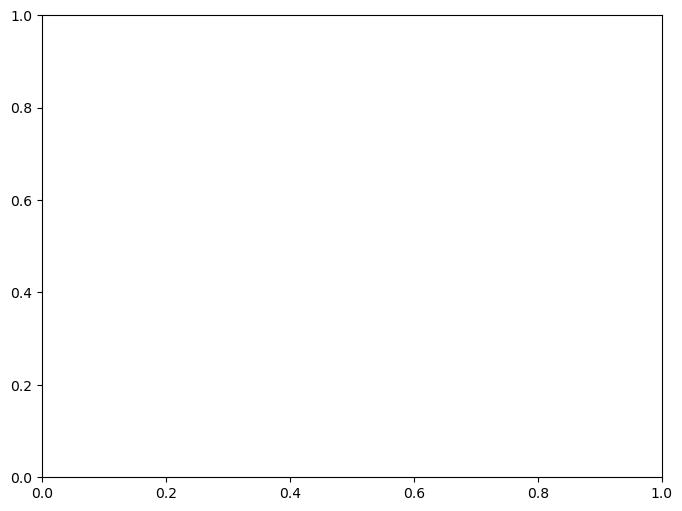

In [83]:
plt.figure(figsize = (8,6))
plt.scatter(X_train, y_train, marker="x")
plt.plot(np.arange(-18,40,1), y_pred.predict(np.arange(-18,40,1).reshape((-1,1))), marker="x", color='C1')
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.show()

In [50]:
def find_knn(x,y,max_k):
    
    err_train = [] 
    err_test = []
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=10)

    for n in np.arange(1,max_k):

        # initialize and fit model
        KNN_reg = KNeighborsRegressor(n_neighbors=n)
        KNN_model = KNN_reg.fit(x_train.reshape((-1,1)), y_train)


        # compute errors
        err_train.append(mean_absolute_error(KNN_model.predict(x_train.reshape((-1,1))), y_train))
        err_test.append(mean_absolute_error(KNN_model.predict(x_test.reshape((-1,1))), y_test))
        
    plt.figure(figsize = (8,6))
    plt.plot(np.arange(1,max_k), err_train, np.arange(1,max_k), err_test)
    plt.legend(["Training", "Validation"])
    plt.xlabel("Number of neighbors")
    plt.ylabel("MAE")
    plt.show()

In [110]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Select a subset of the data to make the process faster
smaller_df = merged_df.sample(n=150000)  # Adjust the number based on your computational resources

# Specify your features and target variable
features = ['station_density', 'city_center_distance', 'boston_university_distance',
       'fenway_park_distance', 'harvard_university_distance', 'mit_distance',
       'boston_common_distance', 'boston_public_garden_distance',
       'newbury_street_distance', 'south_station_distance',
       'north_station_distance', 'back_bay_station_distance', 'temperature']
small_features= ['mit_distance', 'boston_common_distance', 'boston_public_garden_distance']
target = 'idle_time_hours'

# Separate into features (X) and target (y)
X = smaller_df[features]
y = smaller_df[target]

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Create and train the model
model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=42, loss='squared_error')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse}")
print(f"Test R^2: {r2}")

Test MSE: 1.509893760890087
Test R^2: 0.12928719312728654


In [84]:
find_knn(X,y,max_k=20)

ValueError: Found input variables with inconsistent numbers of samples: [2663908, 204916]